## Individuell uppgift – Hälsostudie
## Del 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

df = pd.read_csv("data/health_study_dataset.csv")

### Beskrivande analys
- Beräkning: medel, median, min och max för: age, weight, height, systolic_bp, cholesterol.
- Figur 1: Histogram över blodtryck.
- Figur 2: Boxplot över vikt per kön.
- Figur 3: Stapeldiagram över andelen rökare.

Beskrivande analys:
             age     height   weight  systolic_bp  cholesterol
mean    49.42625  171.84925   73.413   149.178625      4.92915
median  50.00000  171.35000   73.200   149.400000      4.97000
min     18.00000  144.40000   33.700   106.800000      2.50000
max     90.00000  200.40000  114.400   185.900000      7.88000


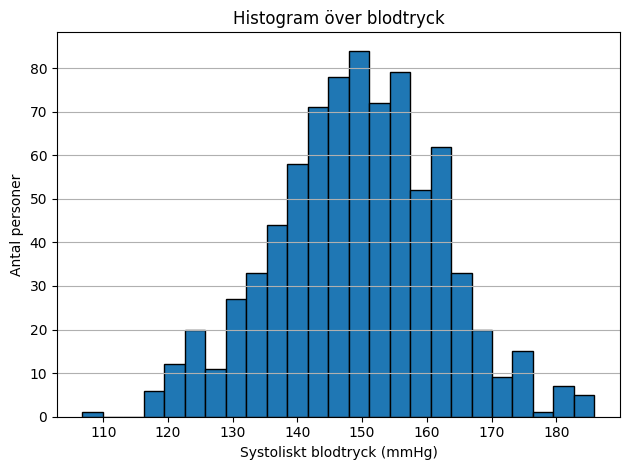

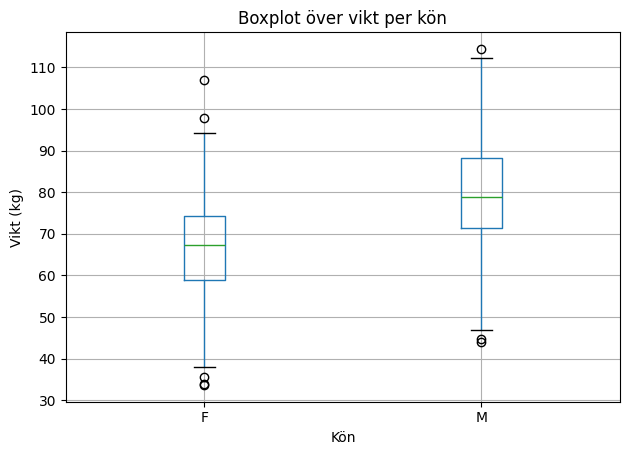

Andelen rökare / icke-rökare:
smoker
No     0.73375
Yes    0.26625
Name: proportion, dtype: float64


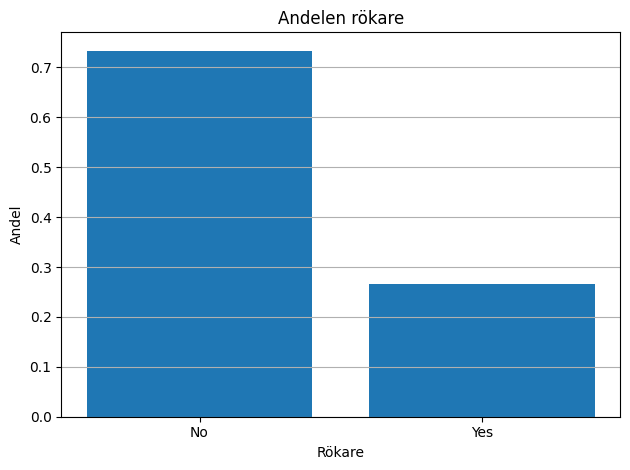

In [2]:
from src.health_analyzer import HealthAnalyzer

analyzer = HealthAnalyzer(df)

print("Beskrivande analys:")
print(analyzer.desc())

analyzer.plot_bp_histogram()
analyzer.plot_weight_sex()

print("Andelen rökare / icke-rökare:")
print(analyzer.smoker_counts())

analyzer.plot_smoker()

### Simulering

In [3]:
analyzer.print_sim_disease()

Simulering av sjukdomsförekomst
----------------------------------
Andelen personer i datasetet som har sjukdomen:      0.059
Andelen personer i simuleringen som har sjukdomen:   0.056
Skillnad:                                            0.003


Resultat: Den simulerade andelen sjukdom ligger nära den verkliga andelen i datasetet. Det visar att variationen beror på slumpen och att simuleringen återspeglar datasetets sjukdomsförekomst väl.

### Konfidensintervall för medelvärdet av systolic_bp

In [4]:
# Metod 1: Normalapproximation

mean_sys = df["systolic_bp"].mean()
std_sys = df["systolic_bp"].std()
n = len(df)
se_sys = std_sys / np.sqrt(n)

print(mean_sys, std_sys, n, se_sys)


149.178625 12.793360316766597 800 0.4523135917074269


In [5]:
def ci_mean_normal(x, confidence=0.95):
    """
    Beräknar ett konfidensintervall för medelvärdet av systoliskt blodtryck
    med hjälp av normalapproximationen.
    """
    x = np.asarray(x, dtype=float)
    mean_sys = float(x.mean())
    std_sys = float(x.std())
    n = len(x)
    z_critical = 1.96
    half_width = z_critical * std_sys / np.sqrt(n)
    lo, hi = mean_sys - half_width, mean_sys + half_width
    return float(lo), float(hi), mean_sys, std_sys, n

lo, hi, mean_sys, std_sys, n = ci_mean_normal(df["systolic_bp"])

print(f"CI = ({lo:.2f}, {hi:.2f}), mean = {mean_sys:.2f}, std = {std_sys:.2f}, n = {n}")

CI = (148.29, 150.06), mean = 149.18, std = 12.79, n = 800


In [6]:
# Metod 2: Bootstrap

np.random.seed(42)

def ci_mean_bootstrap(x, B=1000, confidence=0.95):
    """
    Beräknar ett konfidensintervall för medelvärdet av systoliskt blodtryck
    med hjälp av bootstrap.
    """
    x = np.asarray(x, dtype=float)
    n = len(x)
    boot_means = np.empty(B)
    for b in range(B):
        boot_sample = np.random.choice(x, size=n)
        boot_means[b] = np.mean(boot_sample)

    alpha = (1 - confidence) / 2
    lo, hi = np.percentile(boot_means, [100*alpha, 100*(1 - alpha)])
    return float(lo), float(hi), float(np.mean(x))

blo, bhi, bmean = ci_mean_bootstrap(df["systolic_bp"])

print(f"CI bootstrap = ({blo:.2f}, {bhi:.2f}), mean = {bmean:.2f}")

CI bootstrap = (148.31, 150.10), mean = 149.18


In [7]:
# Jamför resultaten

print(f"CI = ({lo:.2f}, {hi:.2f})")
print(f"CI bootstrap = ({blo:.2f}, {bhi:.2f})")


CI = (148.29, 150.06)
CI bootstrap = (148.31, 150.10)


Resultat:
De två konfidensintervallen (normalapproximation och bootstrap) är nästan identiska. Det tyder på att våra data ligger nära en normalfördelning.

### Hypotesprövning

Hypoteser:
- H0 (nollhypotes): Rökare har inte högre medel-blodtryck än icke-rökare
- H1 (ensidig): Rökare har högre medel-blodtryck än icke-rökare

In [8]:
mean_smokers = df.loc[df['smoker'] == 'Yes', 'systolic_bp'].mean()
mean_nonsmokers = df.loc[df['smoker'] == 'No', 'systolic_bp'].mean()

print("Medel-blodtryck rökare:", mean_smokers)
print("Medel-blodtryck icke-rökare:", mean_nonsmokers)

Medel-blodtryck rökare: 149.524882629108
Medel-blodtryck icke-rökare: 149.05298126064736


Standard t-test:

In [9]:
smoker = df.loc[df["smoker"]=="Yes", "systolic_bp"].values
nonsmoker = df.loc[df["smoker"]=="No", "systolic_bp"].values

# Standard t-test
t_stat, p_value = stats.ttest_ind(smoker, nonsmoker, alternative='greater')

print(f"Standard t-test: t = {t_stat:.3f}, p = {p_value:.4f}")



Standard t-test: t = 0.461, p = 0.3225


- P-värdet (0.3225) är större än signifikansnivån 0.05, vilket innebär att vi inte kan förkasta nollhypotesen.  
- Det finns alltså ingen statistiskt signifikant evidens för att rökare har högre medelvärde av systoliskt blodtryck än icke-rökare i detta dataset.
- Skillnaden som observerats är liten och kan förklaras av slumpen.

### Power

- Simulering för att undersöka hur säkert hypotes­testet är (t.ex. hur ofta testet hittar en skillnad när den finns → power).

In [10]:
from statsmodels.stats.power import TTestIndPower

n_smokers = int((df["smoker"] == "Yes").sum())                                       # antal rökare
n_nonsmokers = int((df["smoker"] == "No").sum())                                     # antal icke-rökare

std_smokers = df.loc[df["smoker"] == "Yes", "systolic_bp"].std()                     # standardavvikelse rökare
std_nonsmokers = df.loc[df["smoker"] == "No", "systolic_bp"].std()                   # standardavvikelse icke-rökare

mean_smokers = df.loc[df['smoker'] == 'Yes', 'systolic_bp'].mean()                   # sanna medel rökare
mean_nonsmokers = df.loc[df['smoker'] == 'No', 'systolic_bp'].mean()                 # sanna medel icke-rökare

sd_pooled = np.sqrt(                                                                 # ungefärlig gemensam standardavvikelse
    ((n_smokers - 1)*std_smokers**2 + (n_nonsmokers - 1)*std_nonsmokers**2) /
    (n_smokers + n_nonsmokers - 2)
    )     
                                                              
d = (mean_smokers - mean_nonsmokers) / sd_pooled                                     # Effektstorlek (Cohen's d)
alpha = 0.05

power_t = TTestIndPower().power(effect_size=d,
                                nobs1=n_smokers,
                                alpha=alpha,
                                ratio=n_nonsmokers / n_smokers,
                                alternative="larger")


print(f"Power: {power_t:.3f}")

Power: 0.118


**Slutsatser hypotesprövning:**
- Jag beräknade hur säkert hypotestestet är med funktionen `TTestIndPower` från statsmodels.  
- Effektstorleken (Cohen’s d) baseras på skillnaden i medelvärde mellan rökare (149.52 mmHg) och icke-rökare (149.05 mmHg).  
- Eftersom skillnaden mellan medelvärden är mycket liten, kommer Cohen's d bli mycket liten, vilket betyder låg power.
- Den beräknade powern är cirka **0.118**, vilket betyder att testet bara har ca **11,8 % chans** att upptäcka en verklig skillnad i systoliskt blodtryck mellan rökare och icke-rökare om den finns.  
- Detta tyder på att testet är **svagt** (låg power), och att ett större urval eller en tydligare skillnad krävs för att kunna hitta ett verkligt samband.


**Källor:**
1. https://www.statsmodels.org/stable/generated/statsmodels.stats.power.TTestIndPower.power.html
2. https://how-to-data.org/how-to-compute-the-power-of-a-test-comparing-two-population-means-in-python-using-statsmodels/
3. https://www.geeksforgeeks.org/python/introduction-to-power-analysis-in-python/
4. Videolektioner

## Del 2

### Utökad analys och visualisering
- Lägg till minst en ny analys eller graf som ger en djupare förståelse (t.ex. relationen mellan blodtryck och ålder, eller sjukdomsförekomst per kön).

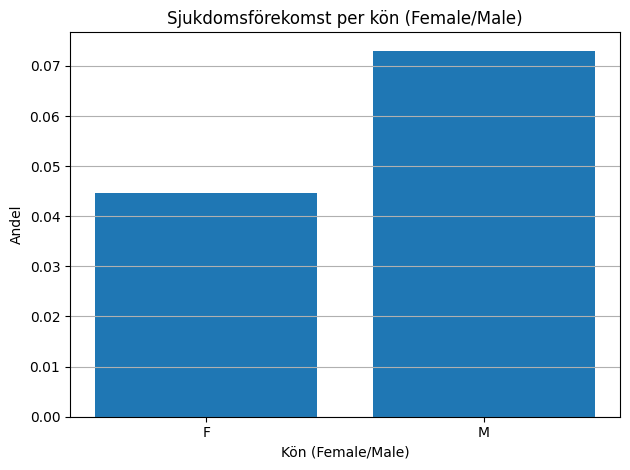

In [11]:
# Stapeldiagram över sjukdomsförekomst per kön:

analyzer.plot_disease()

Figuren visar en högre förekomst av sjukdomen hos män än hos kvinnor.

### Linjär regression

- En enkel linjär regression för att förutsäga blodtryck från ålder.

In [12]:
from sklearn.linear_model import LinearRegression

x_2d = df[["age"]].values
y_1d = df["systolic_bp"].values

linreg = LinearRegression()
linreg.fit(x_2d, y_1d)

sk_intercept = float(linreg.intercept_)
sk_slope = float(linreg.coef_[0])
sk_r2 = float(linreg.score(x_2d, y_1d))
sk_pred_bp = float(linreg.predict(np.array([[50]]))[0])

print(f"""
Enkel linjär regression (Sklearn):
      Skärning = {sk_intercept:.2f}
      Lutning = {sk_slope:.2f}
      R^2 = {sk_r2:.3f}
      Prognos blodtryck (age=50) = {sk_pred_bp:.2f}
      Tolkning lutning: +1 år äldre => + {sk_slope:.2f} mmHg högre blodtryck.
""")


Enkel linjär regression (Sklearn):
      Skärning = 122.68
      Lutning = 0.54
      R^2 = 0.369
      Prognos blodtryck (age=50) = 149.49
      Tolkning lutning: +1 år äldre => + 0.54 mmHg högre blodtryck.



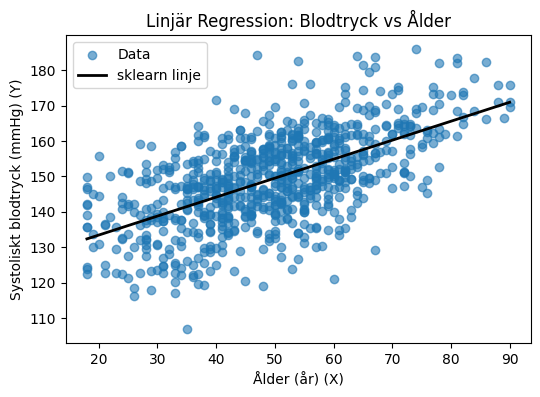

In [13]:
plt.figure(figsize=(6,4))
plt.scatter(df["age"], df["systolic_bp"], alpha=0.6, label="Data", zorder=1)

grid_x = np.linspace(df["age"].min(), df["age"].max(), 200)
grid_y_sklearn = sk_intercept + sk_slope * grid_x

plt.plot(grid_x, grid_y_sklearn, color="black", linewidth=2, label="sklearn linje", zorder=2)

plt.xlabel("Ålder (år) (X)")
plt.ylabel("Systoliskt blodtryck (mmHg) (Y)")
plt.title("Linjär Regression: Blodtryck vs Ålder")
plt.legend()
plt.show()

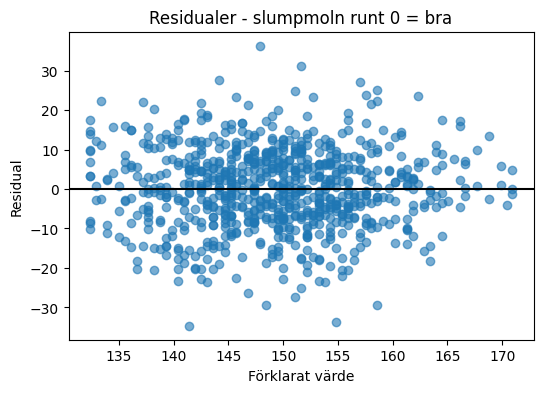

In [14]:
##Residualplot

y_hat = linreg.predict(x_2d)

residuals = y_1d - y_hat

plt.figure(figsize=(6,4))
plt.scatter(y_hat, residuals, alpha=0.6)
plt.axhline(0, color='black', linestyle='-')
plt.xlabel("Förklarat värde")
plt.ylabel("Residual")
plt.title("Residualer - slumpmoln runt 0 = bra")
plt.show()

#### Multipel linjär regression

- En multipel linjär regression för att förutsäga blodtryck från ålder och vikt.

In [15]:
X = df[["age", "weight"]].values
y = df["systolic_bp"].values

regr = LinearRegression()
regr.fit(X, y)

intercept = float(regr.intercept_)
slope_age = float(regr.coef_[0])
slope_weight = float(regr.coef_[1])
r2 = float(regr.score(X, y))
predicted_bp = float(regr.predict(np.array([[50, 80]]))[0])

print(f"""
Multipel linjär regression (Sklearn):
      intercept = {intercept:.2f}
      slope age = {slope_age:.2f}
      slope weight = {slope_weight:.2f}
      R^2 = {r2:.3f}
      prognos bp (age=50, weight=80) = {predicted_bp:.2f}
""")


Multipel linjär regression (Sklearn):
      intercept = 109.50
      slope age = 0.54
      slope weight = 0.18
      R^2 = 0.405
      prognos bp (age=50, weight=80) = 150.66



**Tolkning:**
Ålder och vikt har båda ett positivt samband med systoliskt blodtryck. Modellen förklarar cirka 41 % av variationen (R² = 0.405), en större del än enkel linjär regression. Modellen förutsäger att en 50-årig person som väger 80 kg har ett blodtryck på cirka 151 mmHg. Resultatet visar att båda faktorerna bidrar, men andra faktorer påverkar också blodtrycket.

**Slutsatser del 2:**

- Jag flyttade delar av min kod från del 1 till funktioner och moduler och skapade en mer utvecklad klass (HealthAnalyzer) som kan utföra olika analyser (beskrivande statistik och simulering) och visualiseringar.
- Jag använde scikit-learn för att göra en enkel linjär regression. Den linjära regressionen användes för att undersöka sambandet mellan ålder och blodtryck. Jag följde videolektioner V.8.
- Jag använde scikit-learn även för att göra en multipel regression. Till skillnad från enkel linjär regression kan multipel regression modellera flera förklarande variabler samtidigt, vilket ger en bredare och mer realistisk bild av vilka faktorer som påverkar blodtrycket. Detta gör metoden särskilt lämplig i hälsodata, där variabler såsom ålder och vikt ofta samverkar.

**Källor:**
1. Videolektioner
2. https://www.w3schools.com/python/python_ml_multiple_regression.asp